### Imports

In [3]:
import pandas as pd 
import numpy as np
import os
import glob
import folium
import folium.plugins
import datetime
from folium.plugins import HeatMapWithTime
import statistics
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import json
from shapely.geometry import shape, Point
import geopandas
import pickle

### Area and crime list for user convenience

In [2]:
police_force_area_list = [dic['id'].replace('-',' ') for dic in requests.get("https://data.police.uk/api/forces").json()]

In [3]:
police_force_area_list

['avon and somerset',
 'bedfordshire',
 'cambridgeshire',
 'cheshire',
 'city of london',
 'cleveland',
 'cumbria',
 'derbyshire',
 'devon and cornwall',
 'dorset',
 'durham',
 'dyfed powys',
 'essex',
 'gloucestershire',
 'greater manchester',
 'gwent',
 'hampshire',
 'hertfordshire',
 'humberside',
 'kent',
 'lancashire',
 'leicestershire',
 'lincolnshire',
 'merseyside',
 'metropolitan',
 'norfolk',
 'north wales',
 'north yorkshire',
 'northamptonshire',
 'northumbria',
 'nottinghamshire',
 'northern ireland',
 'south wales',
 'south yorkshire',
 'staffordshire',
 'suffolk',
 'surrey',
 'sussex',
 'thames valley',
 'warwickshire',
 'west mercia',
 'west midlands',
 'west yorkshire',
 'wiltshire']

In [4]:
crime_list = [dic['name'] for dic in requests.get("https://data.police.uk/api/crime-categories?").json()][1:-1]

In [35]:
crime_liste_liste_list

['Anti-social behaviour',
 'Bicycle theft',
 'Burglary',
 'Criminal damage and arson',
 'Drugs',
 'Other theft',
 'Possession of weapons',
 'Public order',
 'Robbery',
 'Shoplifting',
 'Theft from the person',
 'Vehicle crime',
 'Violence and sexual offences']

### Functions for finding files and creating DF

In [5]:
def find_area_files(area): 
    area = area.replace(" ","-")
    files = glob.glob(f'/Users/andrewsmith/Desktop/Crime_Data_project/data/all_data/**/*{area}-street.csv',recursive = True)
    return files

In [6]:
def find_all_files():
    files = glob.glob(f'/Users/andrewsmith/Desktop/Crime_Data_project/data/all_data/**/*-street.csv',recursive = True)
    return files

In [7]:
def create_area_df(area):
    dfs = []
    for file in find_area_files(area): 
        dfs.append(pd.read_csv(file))
    area_df = pd.DataFrame()
    for i in range(len(dfs)): 
        area_df = pd.concat([area_df,dfs[i]]) 
    return area_df
        

### Function for creating a heatmap from user specified area and crime

In [8]:
def area_heat_map(crime_type,area):
    crime_type = crime_type.capitalize()
    area_df = create_area_df(area)
    individual_crime_df = area_df[area_df["Crime type"]==crime_type][['Longitude','Latitude']]
    individual_crime_df=individual_crime_df.dropna()
    lat_list = individual_crime_df['Latitude'].tolist()
    long_list = individual_crime_df['Longitude'].tolist()
    individual_crime_coordinates = set(zip(lat_list,long_list))
    map_centre = (statistics.mean(lat_list), statistics.mean(long_list))
    
    base_map = folium.Map(location=map_centre, zoom_start=10)
    
    title_html = '''
             <h3 align="center" style="font-size:20px"><b>{title} in {location} from 6/2018 to 5/2021</b></h3>
             '''.format(title=crime_type.title(),location=area.title())
    base_map.get_root().html.add_child(folium.Element(title_html))
    
                                       
    folium.plugins.HeatMap(individual_crime_coordinates,overlay=True,min_opacity=0.01).add_to(base_map)
    display(base_map)

In [9]:
area_heat_map('drugs','greater manchester')

### Function for finding a users police area based on co-ordinate inputs

### Function for creating a heatmap from user specified coordinates, crime-radius and crime

### Function for creating a heatmap with time features from user specified area and crime

In [10]:
def heat_map_time(crime_type,area):
    crime_type = crime_type.capitalize()
    area_df = create_area_df(area)
    crime_area_df= area_df[area_df["Crime type"]==crime_type][['Longitude','Latitude','Month']]
    date_index = list(crime_area_df['Month'].sort_values().unique())
    crime_area_df["Time"] = crime_area_df["Month"].map(lambda x:x.replace('-',''))
    crime_area_df["Time"] = crime_area_df["Time"].map(lambda x:int(x))
    crime_area_df = crime_area_df[["Longitude","Latitude","Time"]]
    crime_area_df = crime_area_df.dropna()
    date_list = list(crime_area_df["Time"].unique())
    
   
    lat_long_list = []
    for i in date_list:
        temp=[]
        for index,instance in crime_area_df[crime_area_df['Time'] == i].iterrows():
            temp.append([instance['Latitude'],instance['Longitude']])
        lat_long_list.append(temp)
    
    map_centre = (statistics.mean(crime_area_df['Latitude'].tolist()),statistics.mean(crime_area_df['Longitude'].tolist()))
    base_map = folium.Map(location=map_centre, zoom_start=10)
    HeatMapWithTime(lat_long_list,auto_play=True,position='bottomright',min_opacity=0.1,index=date_index).add_to(base_map)
    display(base_map)

In [11]:
heat_map_time('drugs','north yorkshire')

# Methods for finding crime rates over time (using only West Yorkshire Data)

### Function for getting the population data in a useable format

In [12]:
### Lower layer Super Output Area population estimates is the dataset used
def population_df():
    population_df = pd.read_csv('/Users/andrewsmith/Desktop/Crime_Data_project/data/population_data/population_data.csv',low_memory=False)
    population_df["All Ages"] = population_df["All Ages"].map(lambda x:x.replace(",",""))
    population_df["All Ages"] = population_df["All Ages"].map(lambda x:int(x))
    return population_df

### Function for getting the population of a given police region 

In [13]:
### Crime in England and Wales: Police Force Area data tables is the dataset used
def police_force_area_population(region):
    police_force_area_df = pd.read_csv('/Users/andrewsmith/Desktop/Crime_Data_project/data/population_data/police_area_data_pops_only.csv')
    police_force_area_df = police_force_area_df.drop([0,1]).reset_index(drop=True)
    police_force_area_df.columns = ["Area","Population"]
    police_force_area_df["Population"] = police_force_area_df["Population"].map(lambda x:x.replace("\t",""))
    police_force_area_df["Population"] = police_force_area_df["Population"].map(lambda x:x.replace(",",""))
    police_force_area_df["Population"] = police_force_area_df["Population"].map(lambda x:int(x))
    police_force_area_df["Area"] = police_force_area_df["Area"].map(lambda x:''.join([i for i in x if not i.isdigit()]))
    police_force_area_df["Area"] = police_force_area_df["Area"].map(lambda x:x.lower())
    return int(police_force_area_df[police_force_area_df["Area"]==region]["Population"])


In [14]:
police_force_area_population('west yorkshire')

2320200

### Modified function that creates an additional column as a unique crime identifer

In [15]:
def create_unique_crime_identifier(area_df): 
    area_df["alt ID"] = str((area_df["Latitude"],area_df["Longitude"]))+area_df["Crime type"]
    return area_df

### Modified function that creates an area data frame with alt ID duplicates removed and other crime removed

In [16]:
def create_area_df_mod(area):
    dfs = []
    for file in find_area_files(area): 
        dfs.append(pd.read_csv(file))
    area_df = pd.DataFrame()
    for i in range(len(dfs)): 
        area_df = pd.concat([area_df,dfs[i]]) 
    area_df = create_unique_crime_identifier(area_df)
    area_df.drop_duplicates(subset=['alt ID'])
    area_df = area_df[area_df["Crime type"] != "Other crime"]
    return area_df

In [17]:
def get_area_crime_count(area,crime=None):
    area_df = create_area_df_mod(area)
    crime_type_count_area = area_df[area_df["Crime type"] == crime][["alt ID","Month"]].groupby(by = "Month").count()
    return crime_type_count_area
    

### Function that allows user to input their town/city and returns a dataframe showing all crime for their town

In [18]:
def create_town_df(town):
    west_york_df = create_area_df_mod('west yorkshire')
    town_df = west_york_df[west_york_df['LSOA name'].astype(str).str.contains(town)]
    return town_df

### Creating a function that outputs the total crime count for each crime type in a given month

In [19]:
def get_crime_count(town,crime):
        town_df = create_town_df(town)
        crime_type_count = town_df[town_df["Crime type"] == crime][["alt ID","Month"]].groupby(by = "Month").count()
        return crime_type_count
    

### Creating a function that outputs the population of a given town

In [20]:
def town_population_estimate(town): 
    pop_df = population_df()
    town_population = pop_df[pop_df["LA name (2020 boundaries)"] == town]["All Ages"].sum()
    return town_population
    

In [21]:
town_population_estimate("Bradford")

539776

### Creating a function that outputs the population crime rate for a user specified police area and crime

In [22]:
def get_area_crime_rate(area,crime):
    area_df = get_area_crime_count(area,crime)
    area_pop = police_force_area_population(area)
    return area_df["alt ID"].map(lambda x: x/area_pop*1000)
    

### Creating a function that outputs the population crime rate for a user specified crime and town

In [23]:
def get_crime_rate(town,crime):
    town_df = get_crime_count(town,crime)
    town_pop = town_population_estimate(town)
    return town_df["alt ID"].map(lambda x: x/town_pop*1000)
   

In [24]:
def plot_crime_rate(town,crime):
    crime_rate = get_crime_rate(town,crime)
    plt.figure(figsize=(15,5))
    plt.xticks(rotation = 90)
    plt.plot(crime_rate)
    plt.show;


In [25]:
def plot_crime_rate_alt(town,crime):
    crime_rate = get_crime_rate(town,crime)
    area_crime_rate = get_area_crime_rate('west yorkshire',crime)
    plt.figure(figsize=(18,5))
    sns.set_theme(style="darkgrid")
    sns.lineplot(data=crime_rate,label=f'{town}')
    sns.lineplot(data=area_crime_rate,label='West Yorkshire')
    plt.ylabel("Crime Rate")
    plt.xlabel("")
    plt.xticks(rotation = 45)


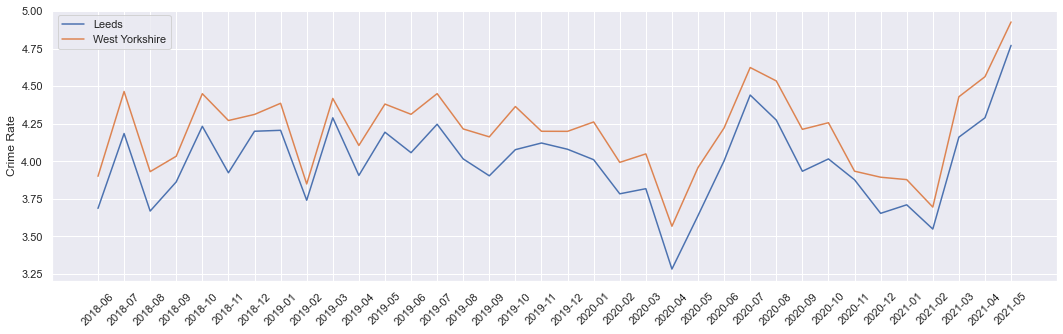

In [36]:
plot_crime_rate_alt("Leeds","Violence and sexual offences")

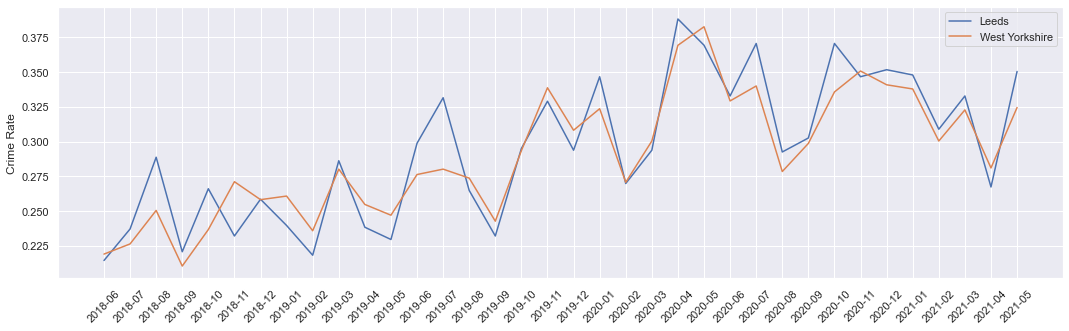

In [27]:
plot_crime_rate_alt("Leeds","Drugs")

### Creating a function that outputs the crime rate for a user specified crime and towns

In [37]:
def plot_crime_rate_comparison(town_1,town_2,crime):
    crime_rate_1 = get_crime_rate(town_1,crime)
    crime_rate_2 = get_crime_rate(town_2,crime)
    plt.figure(figsize=(18,5))
    sns.set_theme(style="darkgrid")
    sns.lineplot(data=crime_rate_1,label=f'{town_1}')
    sns.lineplot(data=crime_rate_2,label=f'{town_2}')
    plt.ylabel("Crime Rate")
    plt.xlabel("")
    plt.xticks(rotation = 45)

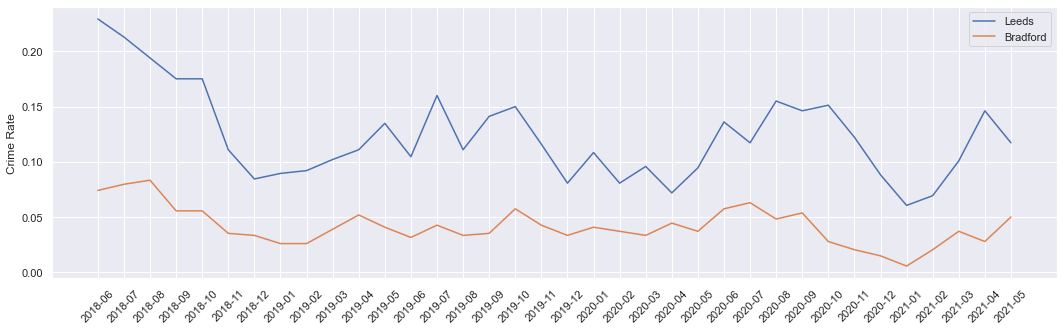

In [38]:
plot_crime_rate_comparison("Leeds","Bradford","Bicycle theft")

### Modifying functions for project workflow

In [ ]:
### user_input = (LSOA,town,police_area)

In [19]:
def open_police_area_pickle(police_area):
    filename = f'/Users/andrewsmith/Desktop/Crime_Data_project/data/pickle_individual_police_force_area_df/{police_area}.pkl'
    infile = open(filename,'rb')
    new_df = pickle.load(infile)
    infile.close()

In [ ]:
def filter_df_by_user_LSOA(LSOA):
    new_df = open_police_area_pickle('durham_constabulary')
    